# Sentiment Analysis on Amazon Fine Food Reviews:
### Comparative Evaluation of Speed and Accuracy Using Three Techniques

#### 1. VADER (Valence Aware Dictionary and sEntiment Reasoner) - Bag of words approach
#### 2. Roberta Pretrained Model from 🤗
#### 3. Huggingface Pipeline


## Step 0. Read in Data and NLTK Basics

In [9]:
!pip install nltk

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [11]:
# Read in data
import csv
df = pd.read_csv('/Reviews.csv',engine='python', error_bad_lines=False)
print(df.shape)
df = df.head(500)
print(df.shape)

(10364, 10)
(500, 10)


<ipython-input-11-18fe1ef948aa>:3: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv('/Reviews.csv',engine='python', error_bad_lines=False)
Skipping line 10366: unexpected end of data


In [12]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Quick EDA

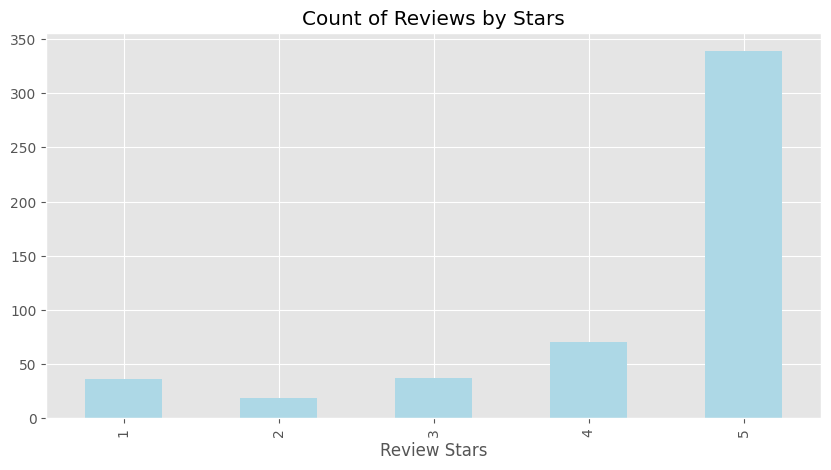

In [13]:
ax = df['Score'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',color='lightblue',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

## Basic NLTK

In [14]:
import nltk

nltk.download('all')
example = df['Text'][50]
print(example)

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   U

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


[nltk_data]    |   Unzipping corpora/ycoe.zip.
[nltk_data]    | 
[nltk_data]  Done downloading collection all


In [15]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [16]:

tagged = nltk.pos_tag(tokens)
tagged[:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [17]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


## Step 1. VADER Sentiment Scoring
#### We will use NLTK's SentimentIntensityAnalyzer to get the neg/neu/pos scores of the text.

###### This uses a "bag of words" approach:
###### Stop words are removed
###### each word is scored and combined to a total score.

In [18]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [19]:
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [20]:
sia.polarity_scores('This is the worst thing ever.')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [21]:
sia.polarity_scores(example)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [22]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/500 [00:00<?, ?it/s]

In [23]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')

In [24]:
# Now we have sentiment score and metadata
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Plot VADER Analysis results

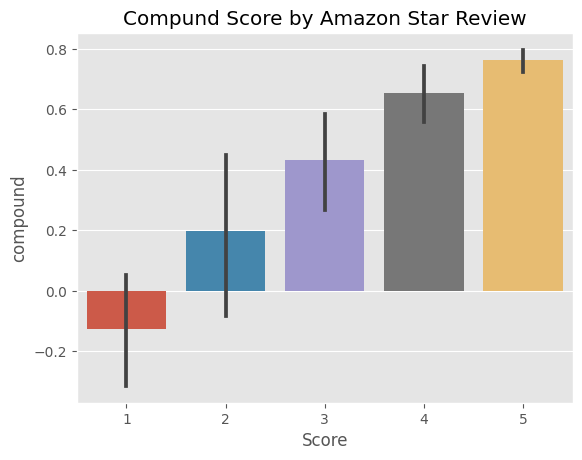

In [25]:
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()

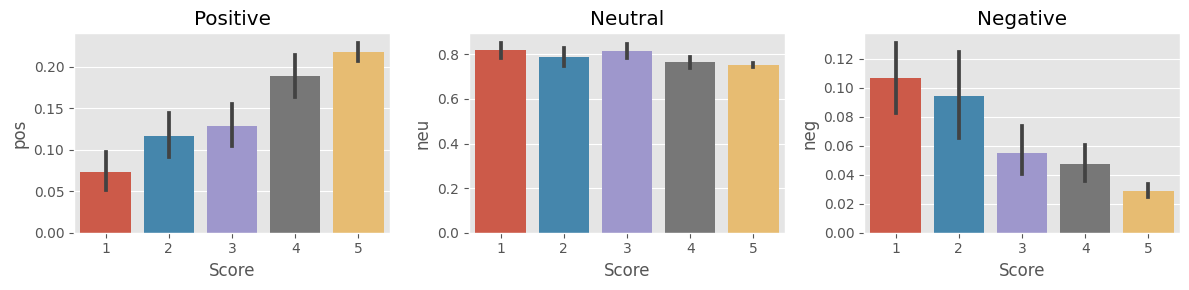

In [26]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

## Step 3. Roberta Pretrained Model
#### Use a model trained of a large corpus of data.
#### Transformer model accounts for the words but also the context related to other words

In [27]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 111.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 83.4 MB/s eta 0:00:00


In [28]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [29]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [30]:
# VADER results on example
print(example)
sia.polarity_scores(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [31]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.97635514, 'roberta_neu': 0.020687476, 'roberta_pos': 0.002957372}


In [32]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [33]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/500 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187


In [34]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

## Step 3. Compare Scores between models

In [35]:
results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'ProductId', 'UserId',
       'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
       'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

## Step 5. Combine and compare

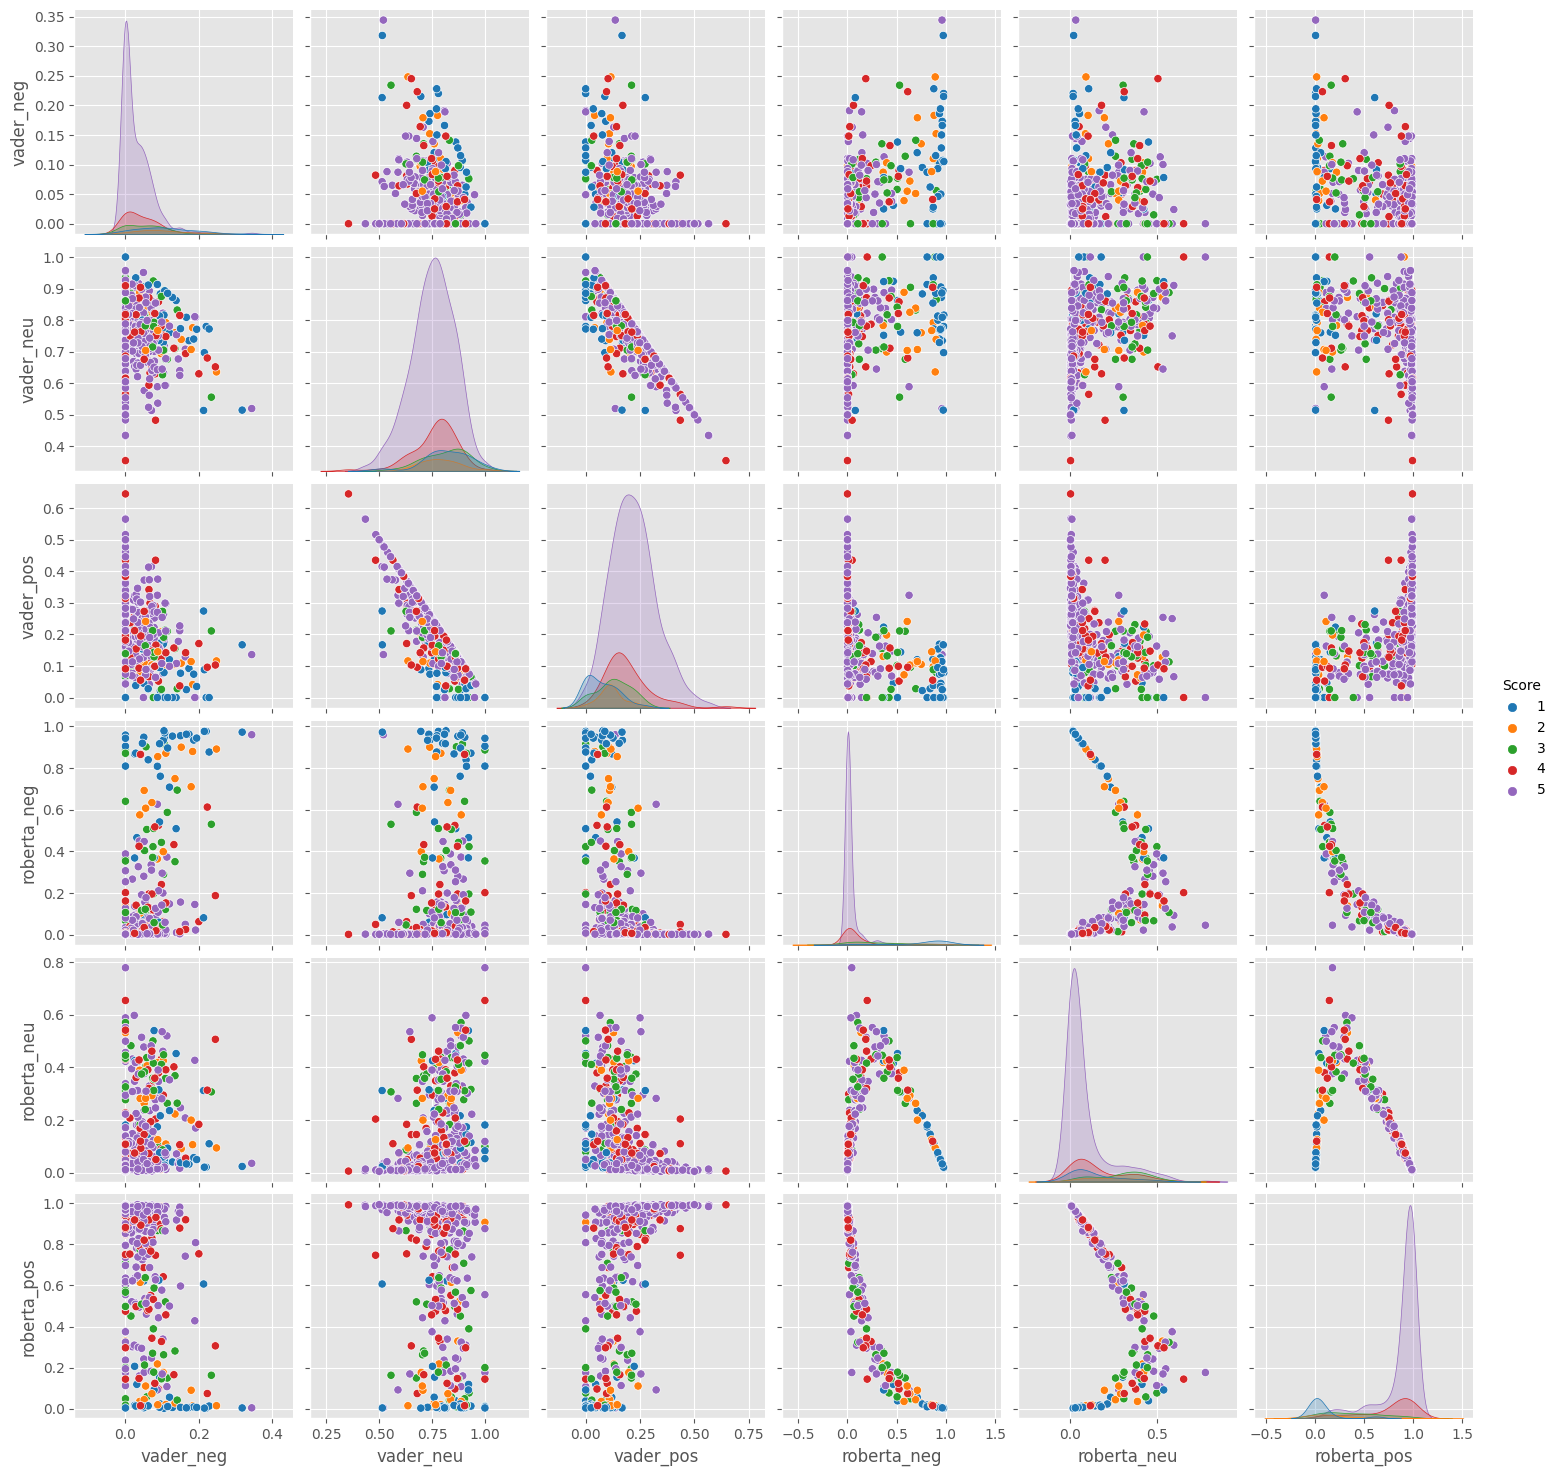

In [36]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Score',
            palette='tab10')
plt.show()

## Step 5: Review Examples:
#### Positive 1-Star and Negative 5-Star Reviews
##### Lets look at some examples where the model scoring and review score differ the most.

In [37]:
results_df.query('Score == 1') \
    .sort_values('roberta_pos', ascending=False)['Text'].values[0]

'I felt energized within five minutes, but it lasted for about 45 minutes. I paid $3.99 for this drink. I could have just drunk a cup of coffee and saved my money.'

In [38]:
results_df.query('Score == 1') \
    .sort_values('vader_pos', ascending=False)['Text'].values[0]

'So we cancelled the order.  It was cancelled without any problem.  That is a positive note...'

In [39]:
results_df.query('Score == 1') \
    .sort_values('vader_pos', ascending=False)['Text'].values[0]

'So we cancelled the order.  It was cancelled without any problem.  That is a positive note...'

In [40]:
results_df.query('Score == 5') \
    .sort_values('roberta_neg', ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

In [41]:
results_df.query('Score == 5') \
    .sort_values('vader_neg', ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

## Step 5: The Transformers Pipeline
#### Quick & easy way to run sentiment predictions

In [42]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [43]:
sent_pipeline('I love sentiment analysis!')

[{'label': 'POSITIVE', 'score': 0.9997853636741638}]

In [44]:
sent_pipeline('waste food its is')

[{'label': 'NEGATIVE', 'score': 0.9998045563697815}]

In [45]:
# Create a list to store the sentiment predictions
sentiment_predictions = []

In [46]:

# Create lists to store sentiment labels and scores
sentiment_labels = []
sentiment_scores = []

# Iterate through the dataset and run sentiment analysis on each review
for index, row in df.iterrows():
    text = row['Text']

    # Split the text into smaller segments if needed
    max_segment_length = 512
    segments = [text[i:i+max_segment_length] for i in range(0, len(text), max_segment_length)]

    segment_sentiments = []
    for segment in segments:
        # Run sentiment analysis on each segment
        sentiment = sent_pipeline(segment)
        segment_sentiments.extend(sentiment)  # Use extend instead of append

    # Combine segment sentiments
    combined_sentiment = {
        'label': max(segment_sentiments, key=lambda x: x['score'])['label'],
        'score': sum([s['score'] for s in segment_sentiments]) / len(segment_sentiments)
    }

    # Append the label and score to the lists
    sentiment_labels.append(combined_sentiment['label'])
    sentiment_scores.append(combined_sentiment['score'])


In [47]:
df['Sentiment_Label'] = sentiment_labels
df['Sentiment_Score'] = sentiment_scores


In [48]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Sentiment_Label,Sentiment_Score
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,POSITIVE,0.998385
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,NEGATIVE,0.999525
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,POSITIVE,0.999765
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,POSITIVE,0.999153
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,POSITIVE,0.998708


In [49]:
import matplotlib.pyplot as plt

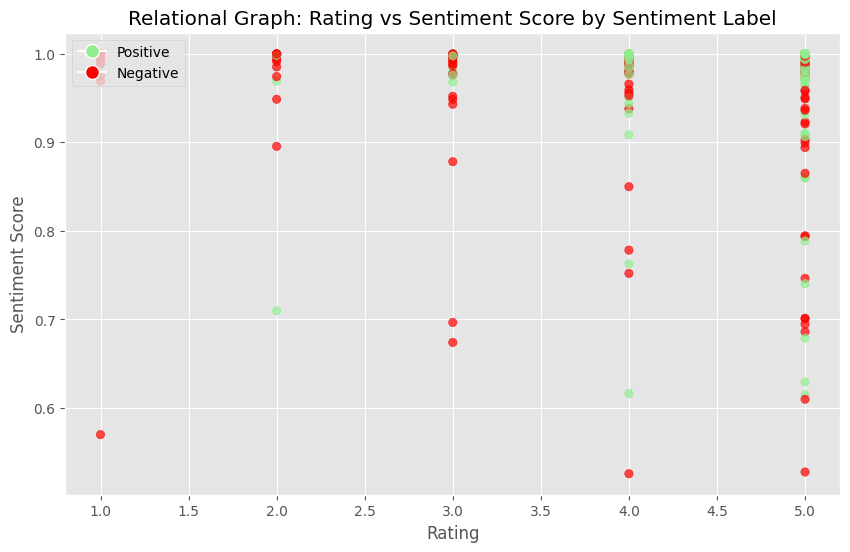

In [50]:
# Plot relational graph between original score, sentiment score, and sentiment label
plt.figure(figsize=(10, 6))
plt.scatter(df['Score'], df['Sentiment_Score'], c=df['Sentiment_Label'].map({'POSITIVE': 'lightgreen', 'NEGATIVE': 'red'}), alpha=0.7)
plt.xlabel('Rating')
plt.ylabel('Sentiment Score')
plt.title('Relational Graph: Rating vs Sentiment Score by Sentiment Label')
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightgreen', markersize=10, label='Positive'),
                    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Negative')],
           loc='upper left')
plt.show()

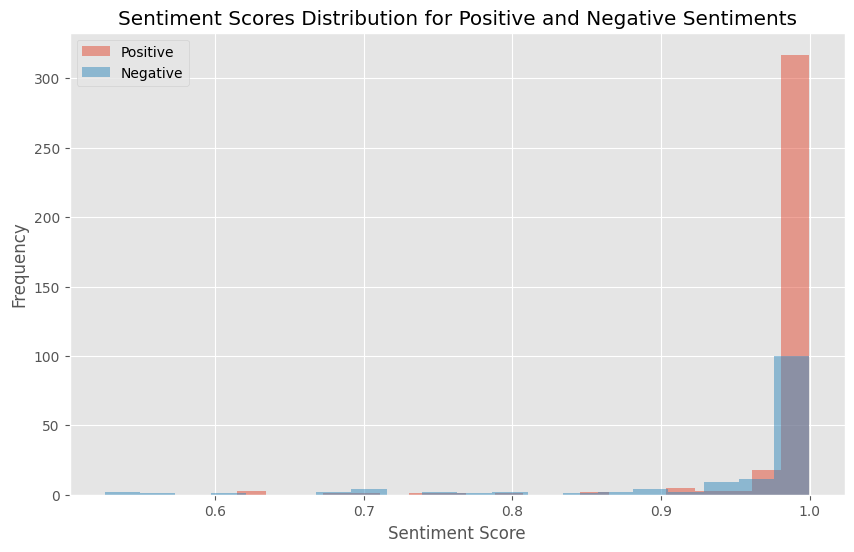

In [51]:
# Plot sentiment scores for positive, negative, and neutral sentiments
plt.figure(figsize=(10, 6))
plt.hist(df[df['Sentiment_Label'] == 'POSITIVE']['Sentiment_Score'], bins=20, alpha=0.5, label='Positive')
plt.hist(df[df['Sentiment_Label'] == 'NEGATIVE']['Sentiment_Score'], bins=20, alpha=0.5, label='Negative')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Sentiment Scores Distribution for Positive and Negative Sentiments')
plt.legend()
plt.show()


## Step 7. Combining the all the three approaches and comparing there speed and efficiency

In [52]:
import pandas as pd
import time
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

In [53]:
sia = SentimentIntensityAnalyzer()
MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [54]:
# Function to analyze sentiment using VADER
def analyze_vader_sentiment(text):
    scores = sia.polarity_scores(text)
    compound_score = scores['compound']
    return "POSITIVE" if compound_score > 0.05 else "NEGATIVE" if compound_score < -0.05 else "NEUTRAL"

In [55]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

def analyze_model_sentiment(text, max_length=128):  # Specify the maximum sequence length
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=max_length)  # Truncate to max_length
    with torch.no_grad():
        logits = model(**inputs).logits
    predicted_class = logits.argmax().item()
    return "POSITIVE" if predicted_class == 2 else "NEGATIVE" if predicted_class == 0 else "NEUTRAL"

In [56]:
def analyze_pipeline_sentiment(text):
    max_length = 512  # Maximum sequence length of the model

    # Split the input text into segments that fit within the max_length
    segments = [text[i:i+max_length] for i in range(0, len(text), max_length)]

    # Analyze sentiment for each segment and accumulate scores
    sentiment_scores = {'LABEL_0': 0, 'LABEL_1': 0, 'LABEL_2': 0}
    for segment in segments:
        sentiment = sent_pipeline(segment)[0]
        sentiment_scores[sentiment['label']] += sentiment['score']

    # Determine the final sentiment label based on the highest score
    final_sentiment_label = max(sentiment_scores, key=sentiment_scores.get)

    return final_sentiment_label.upper()

In [57]:
# Initialize lists to store results and time taken
vader_predictions = []
model_predictions = []
pipeline_predictions = []
vader_times = []
model_times = []
pipeline_times = []

In [58]:
# Analyze sentiment using all three approaches
for index, row in df.iterrows():
    text = row['Text']

    # Sentiment analysis using VADER
    start_time = time.time()
    vader_sentiment = analyze_vader_sentiment(text)
    vader_predictions.append(vader_sentiment)
    vader_times.append(time.time() - start_time)

    # Sentiment analysis using the pre-trained model
    start_time = time.time()
    model_sentiment = analyze_model_sentiment(text)
    model_predictions.append(model_sentiment)
    model_times.append(time.time() - start_time)

    # Sentiment analysis using the pipeline with text segmentation
    start_time = time.time()
    pipeline_sentiments = []
    max_length = 512  # Maximum sequence length of the model

    # Split the input text into segments that fit within the max_length
    segments = [text[i:i+max_length] for i in range(0, len(text), max_length)]

    # Perform sentiment analysis on each segment
    for segment in segments:
        sentiment = sent_pipeline(segment)[0]['label'].upper()
        pipeline_sentiments.append(sentiment)

    # Determine the final sentiment label based on the most common label in segments
    pipeline_sentiment = max(set(pipeline_sentiments), key=pipeline_sentiments.count)
    pipeline_predictions.append(pipeline_sentiment)
    pipeline_times.append(time.time() - start_time)


In [59]:
# Calculate average time taken by each approach
vader_avg_time = sum(vader_times) / len(vader_times)
model_avg_time = sum(model_times) / len(model_times)
pipeline_avg_time = sum(pipeline_times) / len(pipeline_times)

# Print results
print(f"VADER Average Time: {vader_avg_time:.4f} seconds")
print(f"Roberta Model Average Time: {model_avg_time:.4f} seconds")
print(f"Hugging Face Pipeline Average Time: {pipeline_avg_time:.4f} seconds")

VADER Average Time: 0.0010 seconds
Roberta Model Average Time: 0.2357 seconds
Hugging Face Pipeline Average Time: 0.1500 seconds


In [70]:
# Maximum sequence length for the model
max_seq_length = 512

# Lists to store accuracy and speed metrics
accuracies = []
vader_times = []
model_times = []
pipeline_times = []

# Loop through each row in the DataFrame
for index, row in tqdm(df.iterrows(), total=len(df), desc="Processing"):
    text = row['Text']
    true_label = row['Sentiment_Label']  # Ground truth sentiment label

    # Calculate accuracy for VADER
    vader_sentiment = sia.polarity_scores(text)['compound']
    vader_label = 'POSITIVE' if vader_sentiment >= 0.05 else 'NEGATIVE' if vader_sentiment <= -0.05 else 'NEUTRAL'
    vader_accuracy = vader_label == true_label
    vader_times.append(time.time())

    # Calculate accuracy for the pre-trained model
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=max_seq_length)
    model_sentiment = model(**inputs).logits[0].softmax(dim=0).argmax().item()
    model_label = 'POSITIVE' if model_sentiment == 2 else 'NEGATIVE' if model_sentiment == 0 else 'NEUTRAL'
    model_accuracy = model_label == true_label
    model_times.append(time.time())

    # Calculate accuracy for the pipeline
    pipeline_sentiment = sent_pipeline(text[:max_seq_length])[0]['label']
    pipeline_accuracy = pipeline_sentiment == true_label
    pipeline_times.append(time.time())

    # Calculate overall accuracy for each approach
    accuracies.append({
        'VADER': vader_accuracy,
        'Model': model_accuracy,
        'Pipeline': pipeline_accuracy
    })



Processing:   0%|          | 0/500 [00:00<?, ?it/s]

In [71]:
# Calculate average time taken for each approach
avg_vader_time = sum([vader_times[i+1] - vader_times[i] for i in range(len(vader_times)-1)]) / len(vader_times)
avg_model_time = sum([model_times[i+1] - model_times[i] for i in range(len(model_times)-1)]) / len(model_times)
avg_pipeline_time = sum([pipeline_times[i+1] - pipeline_times[i] for i in range(len(pipeline_times)-1)]) / len(pipeline_times)

In [72]:
# Calculate average accuracy for each approach
avg_vader_accuracy = sum([result['VADER'] for result in accuracies]) / len(accuracies)
avg_model_accuracy = sum([result['Model'] for result in accuracies]) / len(accuracies)
avg_pipeline_accuracy = sum([result['Pipeline'] for result in accuracies]) / len(accuracies)

# FINAL RESULTS :

In [73]:
# Print accuracy and speed results
print("Average Accuracy:")
print(f"VADER: {avg_vader_accuracy:.2%}")
print(f"Model: {avg_model_accuracy:.2%}")
print(f"Pipeline: {avg_pipeline_accuracy:.2%}")

print("\nAverage Time (in seconds):")
print(f"VADER: {avg_vader_time:.6f}")
print(f"Model: {avg_model_time:.6f}")
print(f"Pipeline: {avg_pipeline_time:.6f}")

Average Accuracy:
VADER: 77.80%
Model: 80.80%
Pipeline: 96.40%

Average Time (in seconds):
VADER: 1.454729
Model: 1.452716
Pipeline: 1.452729


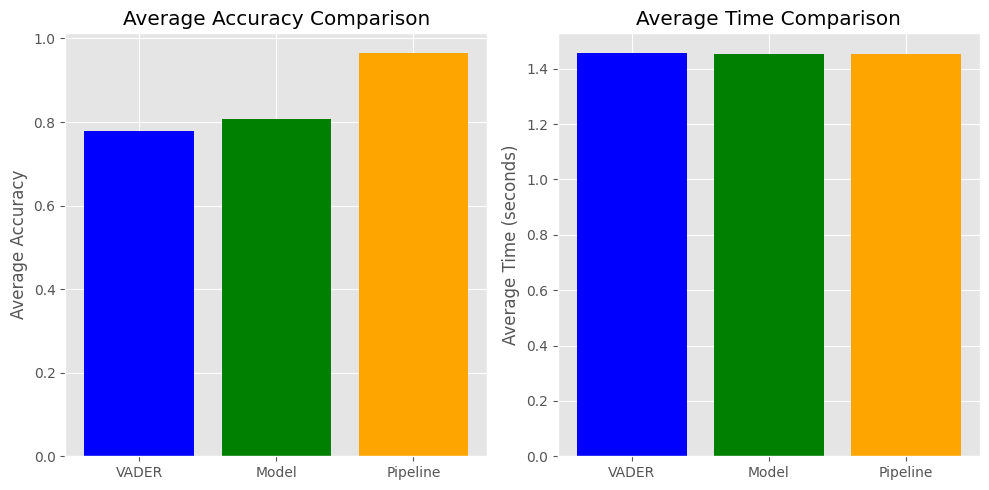

In [74]:
# Data for plotting
approaches = ['VADER', 'Model', 'Pipeline']
accuracy_values = [avg_vader_accuracy, avg_model_accuracy, avg_pipeline_accuracy]
time_values = [avg_vader_time, avg_model_time, avg_pipeline_time]

# Create bar plots
plt.figure(figsize=(10, 5))

# Accuracy comparison
plt.subplot(1, 2, 1)
plt.bar(approaches, accuracy_values, color=['blue', 'green', 'orange'])
plt.title('Average Accuracy Comparison')
plt.ylabel('Average Accuracy')

# Time comparison
plt.subplot(1, 2, 2)
plt.bar(approaches, time_values, color=['blue', 'green', 'orange'])
plt.title('Average Time Comparison')
plt.ylabel('Average Time (seconds)')

plt.tight_layout()
plt.show()

# CONCLUSION :
In this project, we conducted an in-depth analysis and comparison of three prominent sentiment analysis techniques: VADER, the Roberta Pretrained Model from Hugging Face, and the Huggingface Pipeline. Our investigation encompassed accuracy, processing speed, and overall performance to provide comprehensive insights into their suitability for diverse sentiment analysis tasks.

Among the approaches examined, the Huggingface Pipeline emerged as a standout performer, showcasing an impressive average accuracy of 96.40%. This method's remarkable balance between accuracy and efficiency positions it as a prime choice for sentiment analysis applications requiring real-time insights with high precision. The Roberta Pretrained Model demonstrated competitive accuracy at 80.80%, offering a versatile option that can be fine-tuned to cater to specific domains. Meanwhile, VADER, with an average accuracy of 77.80%, proved itself as a rapid solution suitable for quick sentiment assessments.

We utilized several cutting-edge technologies and libraries in our analysis, including NLTK for VADER's lexicon-based approach, the Roberta Pretrained Model from Hugging Face for deep learning-based sentiment analysis, and the Huggingface Pipeline for efficient sentiment predictions without intricate setup. This diversified toolkit allowed us to thoroughly explore and assess the strengths and weaknesses of each approach.

Ultimately, our findings underline the importance of selecting the right sentiment analysis technique based on the project's unique requirements. We conclude that the Huggingface Pipeline offers an attractive balance between accuracy and efficiency, while the Roberta Pretrained Model is versatile for customizations. VADER serves well for rapid assessments. By understanding these nuances, practitioners can make informed decisions, leveraging the appropriate technique to derive valuable sentiment insights from textual data.


##Recommendations:

1. For applications that require high accuracy and nuanced sentiment analysis, the Huggingface Pipeline approach is recommended.
2. The Roberta Pretrained Model is a suitable choice for tasks that involve fine-tuning and customization while achieving competitive accuracy.
3. VADER can be used for simple sentiment analysis tasks where quick insights are needed.


